# Import packages

In [1]:
from array import array
import itertools
import time
import math

import rootpy.plotting.root2matplotlib as rplt
from rootpy.plotting.style import get_style, set_style
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import matplotlib.pyplot as plt
import numpy as np

import astroML.plotting as aml
import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from matplotlib.ticker import NullFormatter


Welcome to JupyROOT 6.13/01


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py:252: RuntimeWarning: creating converter for unknown type "_Atomic(bool)"
  value = getattr(object, key)


# File

In [2]:
#RootFile = "Same_Event_Correlation.root"
RootFile = "Same_Event_Correlation_ITS_ISO.root "
#RootFile = "Mix_Event_Correlation.root"
#RootFile = 'Same_Mix_Ratio.root'

# Define Bins

In [3]:
#FIXME: Read from Corr_config.yaml
zTbins = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
pTbins = [10, 11, 12.5, 16]

# Plot Titles

In [4]:
def Plot1D (histo, ptbin, ztbin,DNN_Bool):
    histo.SetTitle("#gamma-hadron: p_{T}^{Clus.}(%1.1f-%1.1f),  z_{T}(%1.2f-%1.2f)"
                   %(pTbins[ptbin],pTbins[ptbin+1],zTbins[ztbin],zTbins[ztbin+1]))
    histo.GetXaxis().SetTitle("#Delta#phi")
    histo.GetYaxis().SetTitle("#frac{1}{N_{trig}} #frac{d^{2}N}{d#phid#eta}")
    histo.GetYaxis().SetTitleOffset(1)
    if not(DNN_Bool):
        histo.SetLineColor(2)

# Phi Projection & ZYAM

<sup>**NOTE**: The DNN corresponding to one photon is reflected in the naming scheme of histograms, where DNN1_Histo is signal (the same here) but background (DNN corresponding to 2 photons) is DNN2_Histo. Here, the DNN variable is a boolian corresponding to *true for signal*, *false for background* (not signal)<sup>

In [5]:
def GetPhiProj(filename, ipt, izt, Signal_DNN=True, doZYAM=True):

    DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
    file = ROOT.TFile(filename)
    histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                       %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],10*zTbins[izt+1]))
    #integra
    Eta_Axis = histo2D.GetYaxis()
    PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                  %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],10*zTbins[izt],
                                    10*zTbins[izt+1]),Eta_Axis.FindBin(-0.6),Eta_Axis.FindBin(0.6));
    PhiProjection.SetDirectory(0)
    PhiProjection.Scale(1.0/1.2) #scale by eta region
    ntriggers = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    
    if not(ntriggers == None):
        PhiProjection.Scale(1.0/ntriggers.GetEntries()) #per trigger yield
    
    Plot1D(PhiProjection,ipt,izt,Signal_DNN)
    
    zyam = PhiProjection.Integral(11,13)/3
    # how do I plot ZYAM, perhaps in both cases?
    #print('ZYAM=%f'%(zyam))
    if(doZYAM):
        for i in range(25):
            y = PhiProjection.GetBinContent(i)
            y_error = PhiProjection.GetBinError(i)
            new_y = y-zyam
            PhiProjection.SetBinContent(i,new_y)
            #assumes 0 error in ZYAM
            new_y_error = y_error
            PhiProjection.SetBinError(i,new_y_error) 
    file.Close()
    return PhiProjection

<sup>**NOTE**: SetDirectory(0) needed because when a file in root is called, the gDirectory is changed to point to it. The creation of a histogram (PhiProjection) is associated to that file and contains a local reference, which is destroyed when the function exits. Thus, returns 'None' unless the Directory (reference) is changed. Root is annoying.</sup>

#### Plot Signal & Background

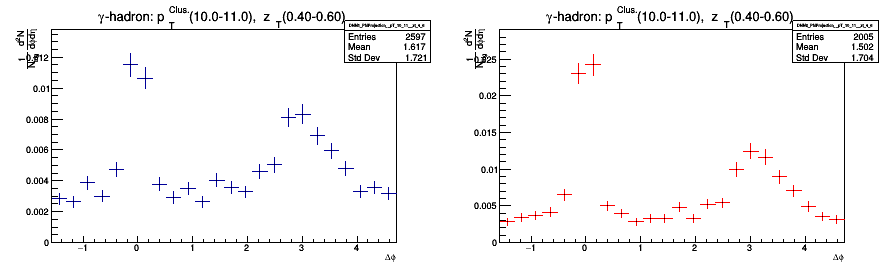

In [6]:
canv = ROOT.TCanvas("canv","canv",900,300)
canv.Divide(2)
Sig = GetPhiProj(RootFile,0,3,True,False)#equal to returned plot
canv.cd(1)
sig_max = 1.2*Sig.GetMaximum()
Sig.GetYaxis().SetRangeUser(0,sig_max)
Sig.Draw()
bkgd = GetPhiProj(RootFile,0,3,False,False)
canv.cd(2)
bkgd.SetLineColor(2)
bkgd_max = 1.2*bkgd.GetMaximum()
bkgd.GetYaxis().SetRangeUser(0,bkgd_max)
bkgd.Draw()
canv.Draw()

# Low DNN Purity Scaling and Subtraction

In [7]:
def GetBKGsubtracted(filename, ptbin, ztbin, doZYAM=True, doSubtraction=True):
    Signal = GetPhiProj(filename,ptbin,ztbin,True,doZYAM)
    Background = GetPhiProj(filename,ptbin,ztbin,False,doZYAM)
    #purity = GetBinContent(ptbin)
    purity = 0.4
    Background.Scale(1-purity)
    if (doSubtraction):
        Signal.Add(Background,-1)
        #Root handles errors correctly. Have checked with manual quadrature sum
    return Signal,Background

### Check

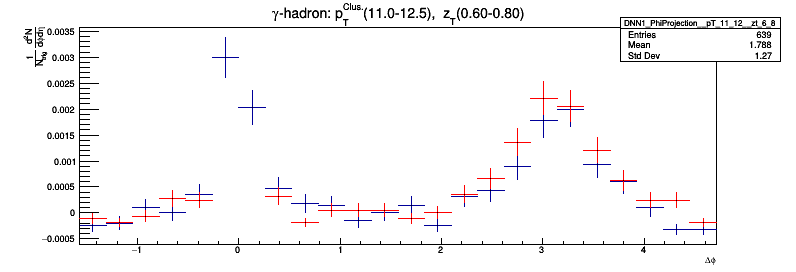

In [8]:
DoSubtraction = False
c = ROOT.TCanvas("c","c",800,300)
hsig,hbkd = GetBKGsubtracted(RootFile,1,4,True,DoSubtraction)
hsig.Draw()
if not(DoSubtraction):
    hbkd.SetLineColor(2)
    hbkd.Draw("same")
c.Draw()
#ROOT.disableJSVis()

# Loop and Plot

In [9]:
def Looping(filename,DoZYAM,DoSub=True):
    canvases = []
    for ptbin in range(3):
        canvases.append(ROOT.TCanvas("canv%i"%(ptbin),"canv",2500,2000))
        canvases[ptbin].Divide(2,3)
        for ztbin in range(6):
            hsig,hbkg = GetBKGsubtracted(filename,ptbin,ztbin,DoZYAM,DoSub)#doZYAM,doSubtraction
            canvases[ptbin].cd(ztbin+1) 
            
            #set range
            ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
            hsig.GetYaxis().SetRangeUser(0,ymax)
            hbkg.GetYaxis().SetRangeUser(0,ymax)
            
            #plot Signal
            #Plot1D(hsig,ptbin,ztbin,True)
            hsig.Draw()
            
            #Overlay
            if not(DoSub): 
                #Plot1D(hbkg,ptbin,ztbin,False)
                hbkg.Draw("same")
                canvases[ptbin].Update()
            canvases[ptbin].Draw()
        if (DoSub): canvases[ptbin].SaveAs('pics/correlations_Subtracted_ptbin%i.png'%(ptbin))
        else: canvases[ptbin].SaveAs('pics/correlations_Overlay_ptbin%i.png'%(ptbin))
    return canvases

INFO:ROOT.TCanvas.Print] png file pics/correlations_Overlay_ptbin0.png has been created
INFO:ROOT.TCanvas.Print] png file pics/correlations_Overlay_ptbin1.png has been created
INFO:ROOT.TCanvas.Print] png file pics/correlations_Overlay_ptbin2.png has been created


[<ROOT.TCanvas object ("canv0") at 0x7f8b2171c610>,
 <ROOT.TCanvas object ("canv1") at 0x7f8b21623fa0>,
 <ROOT.TCanvas object ("canv2") at 0x7f8b21635380>]

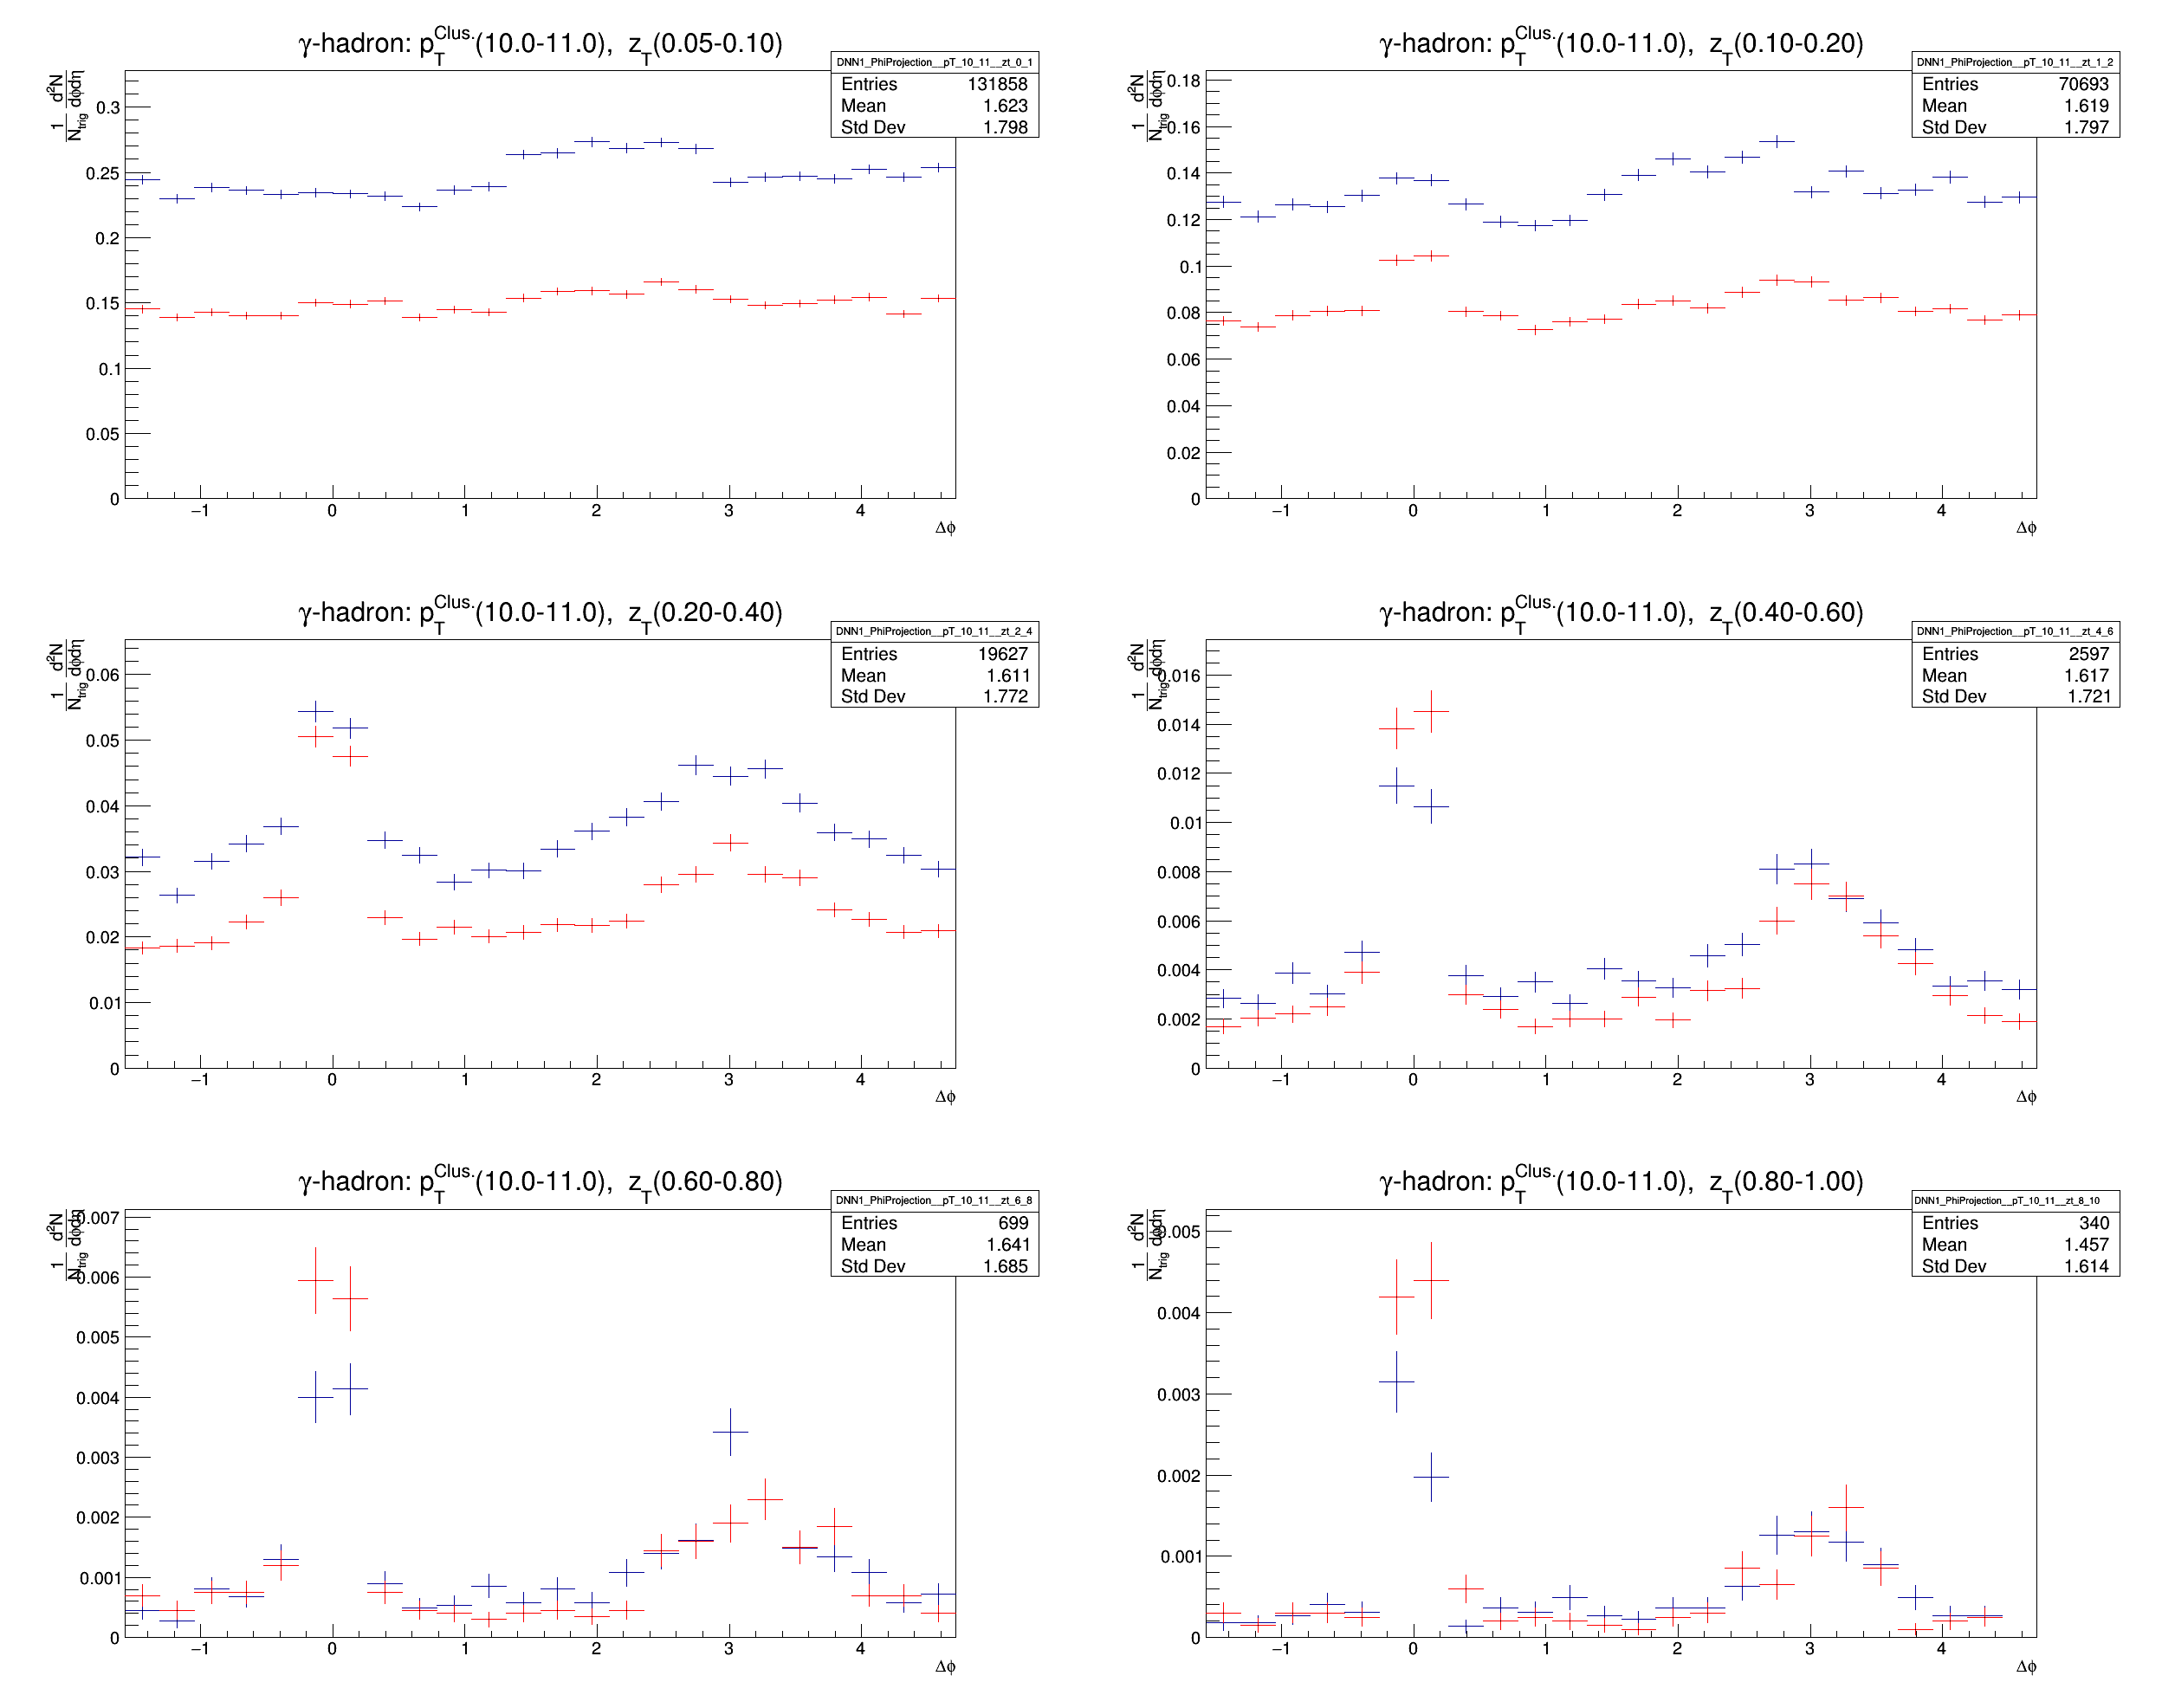

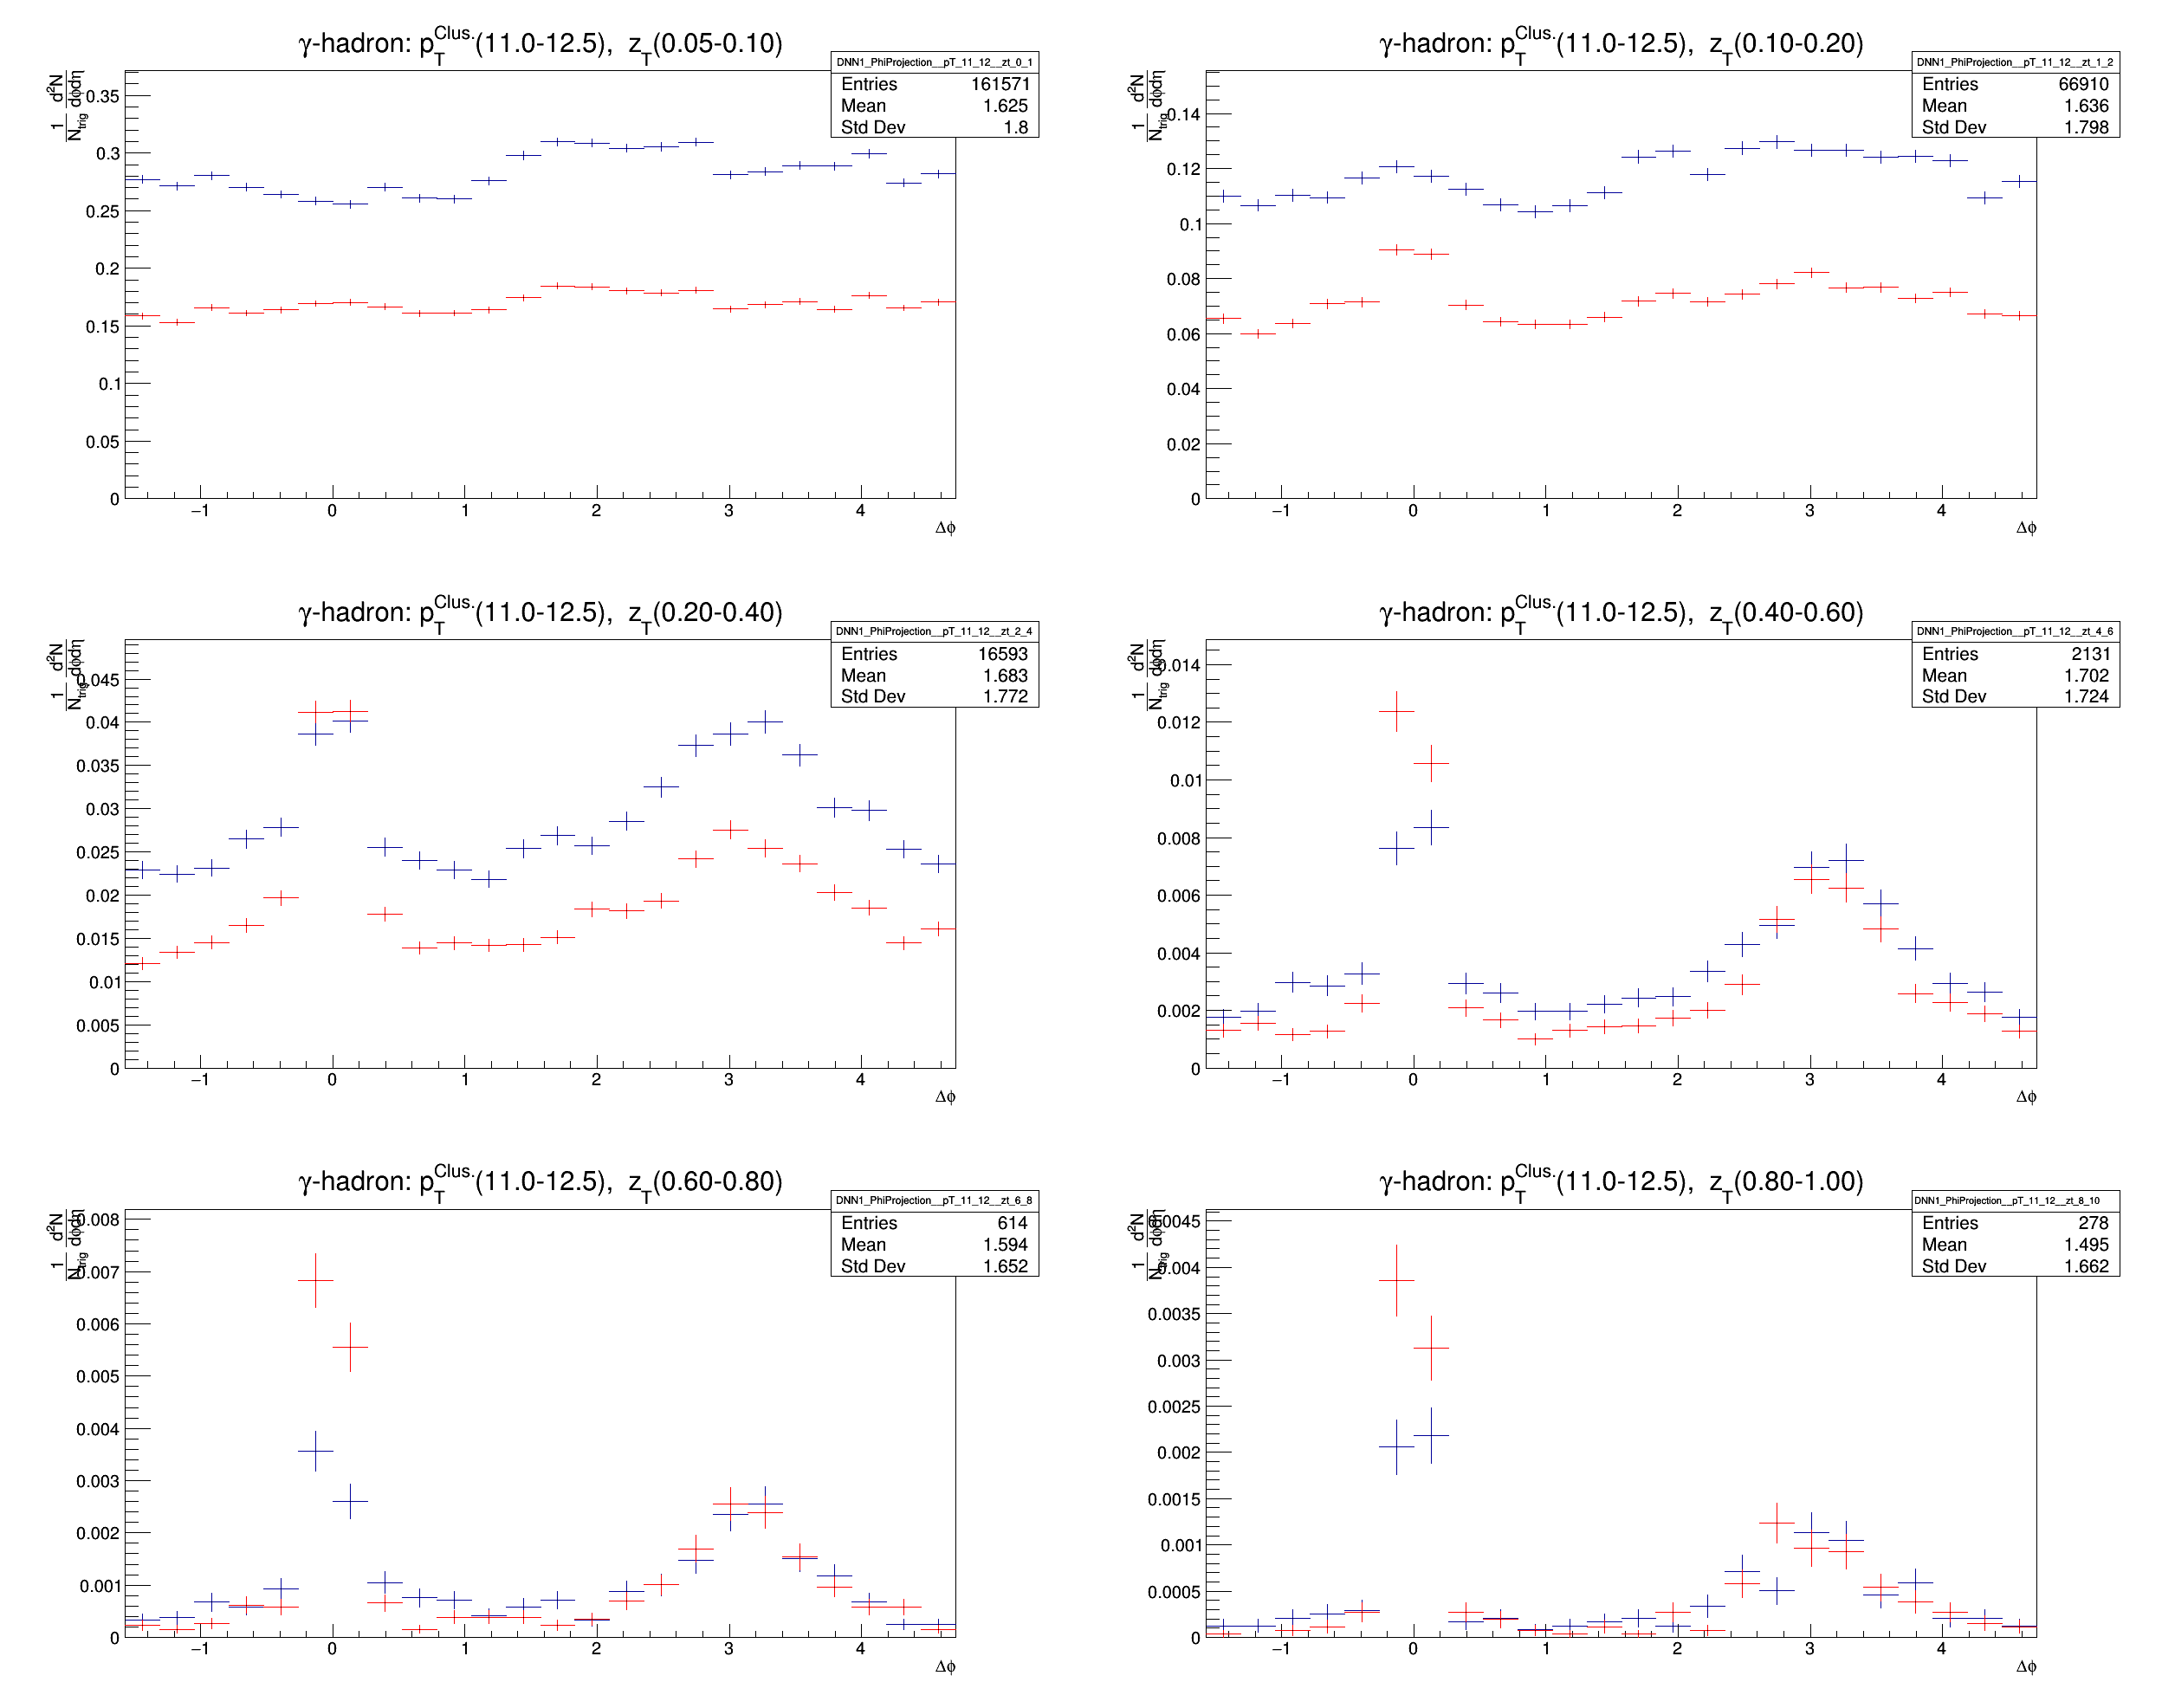

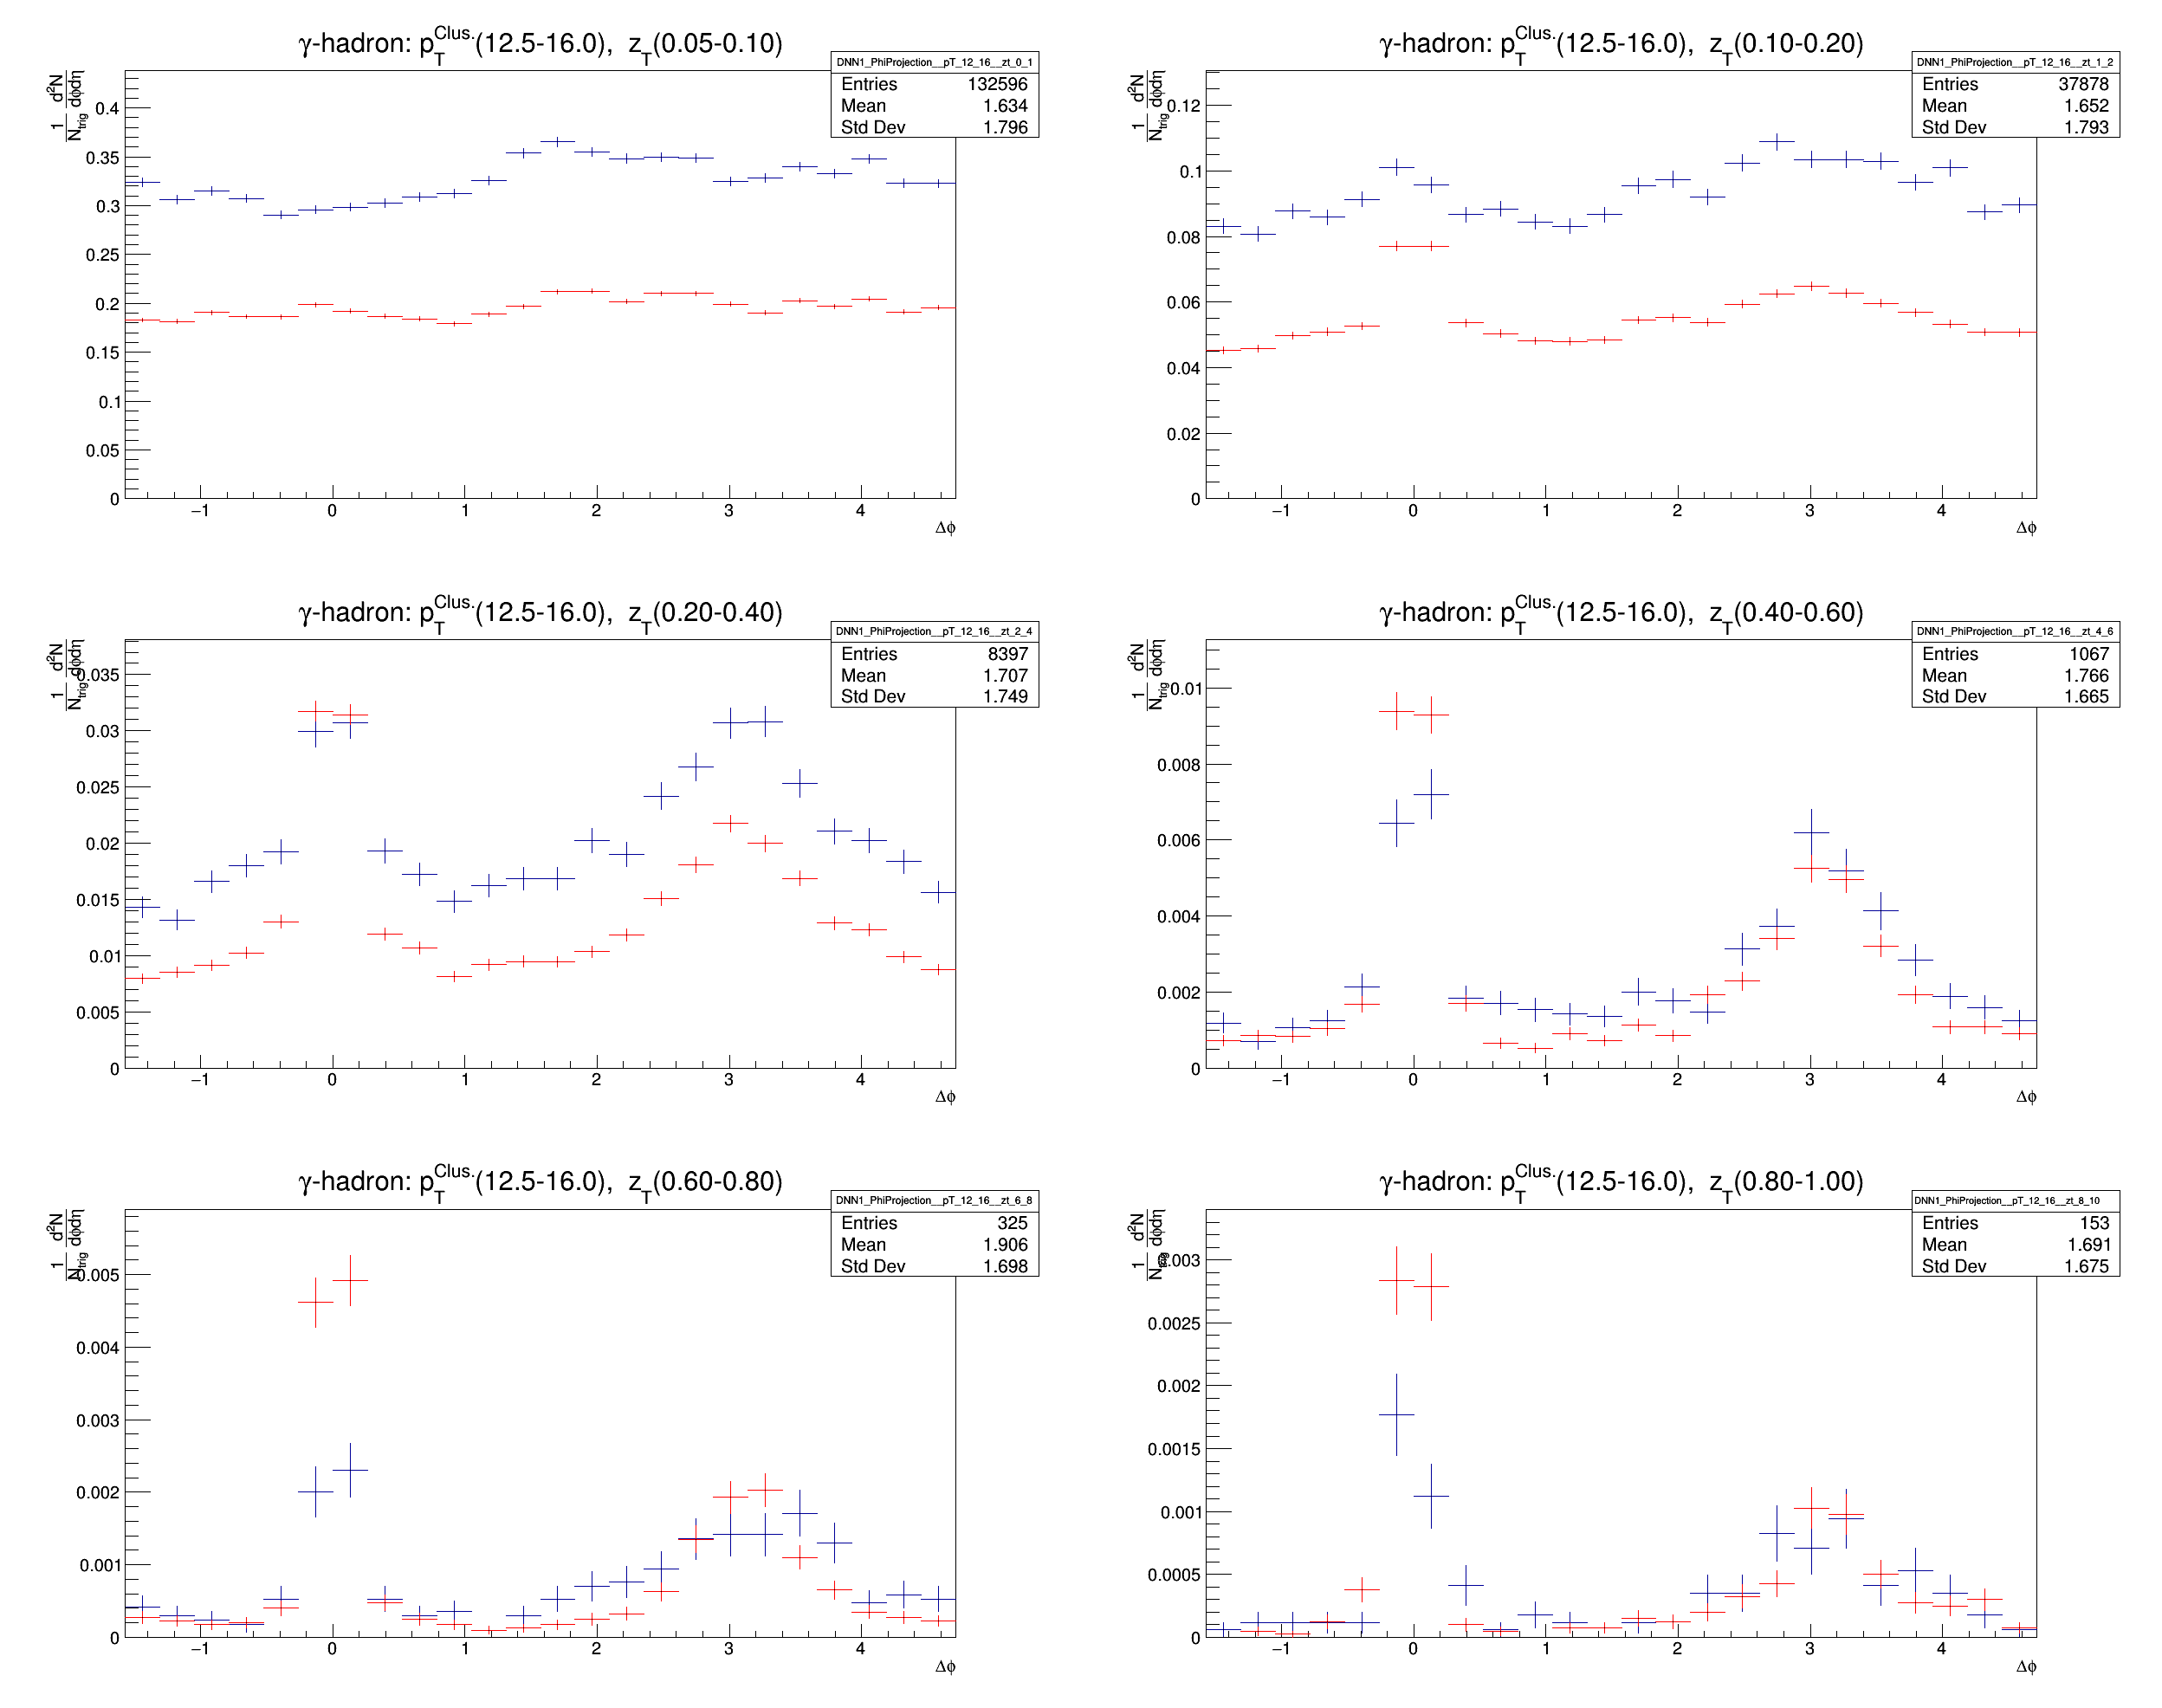

In [10]:
Looping(RootFile,False,False)#Filename,DoZYAM,DoSub